# Initialisations

In [1]:
import pandas as pd ; pd.set_option('display.max_columns', 500) # dataframes
import numpy as np # mathsy bits
import ipywidgets as widgets # widgets

from sklearn.model_selection import train_test_split #split data into train and test sets

# feature selection + gridsearch
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import GridSearchCV

# models
from sklearn.linear_model import Lars, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

import joblib # saving models
from datetime import datetime # get time for labelling saved models

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

import mpld3 # hover-over labels for plots
mpld3.disable_notebook()

train_scores = dict() ; test_scores  = dict() #to hold scores for viewing at the end

In [13]:
def grid_search_return_hp_dict(model, X_train_gs, y_train_gs, param_grid):
    """Run GridSearchCV on given model with defined param_grid, return best params as dict.
    Pre-assign sklearn model to variable. Pass param_grid as dict."""
    print(str(model).split(sep='(')[0], "grid search.")
    GS = GridSearchCV(model, param_grid, n_jobs=2)
    GS.fit(X_train_gs, y_train_gs)
    print(GS.best_params_)
    return(GS.best_params_)

def produce_exp_vs_pred_df(features_list, model, codename):
    """Pass features_list as a string"""
    pred_list = []
    for i in range(0, len(dragon_features)):
        prediction = model.predict([dragon_features[eval(features_list)].iloc[i]])
        pred_list.append(prediction)
    train_scores.update({codename : model.score(X_train, y_train)})
    test_scores.update({codename : model.score(X_test, y_test)})
    
    print('Training Score:\t', model.score(X_train, y_train))
    print('Testing Score:\t', model.score(X_test, y_test))
    
    exp_vs_calc = pd.DataFrame(constants_first)
    exp_vs_calc['Predicted'] = pred_list
    exp_vs_calc.rename({'Kh_first':'Experimental'}, inplace=True, axis=1)
    
    now = datetime.now()

    dt_string = now.strftime("_%d_%m_%Y_%H_%M_%S")
    filename = "models/DRAGON_noVPAS/" + str(model).split(sep='(')[0] + "_" + features_list[16:] + dt_string + ".joblib"
    print(str(model).split(sep='(')[0], "run at:", now, ". Saving to", filename)
    
    joblib.dump(model, filename)
    return exp_vs_calc

def prediction_plot_scores(model_func, pred_df):
    """Print train+test scores, then plot scatter of predicted vs actual HLCs. Uses {X/y}_{train/test},
    redefining these variables will change the output."""
    print('Training Score:\t', model_func.score(X_train, y_train))
    print('Testing Score:\t', model_func.score(X_test, y_test))
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(pred_df['Experimental'], pred_df['Predicted'])
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    plt.title('%s predictions of HLCs' %str(model_func).split(sep='(')[0])
    labels = ['{}'.format(i) for i in species_names]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)
    plt.plot([-30, 10], [-30, 10], c='red')
    plt.show()

# DRAGON descriptors
## Bringing in data and splitting it into parts

In [3]:
csv = pd.read_csv('organics_noVPAS_desc_kh.csv') # contains VP/AS HLCs

print("Input Shape", csv.shape) #input shape

csv.dropna(axis=0, inplace=True)

print("Removed NaN, new shape", csv.shape) #removed NaN shape

species_names = csv.pop('Unnamed: 0')
smiles_strings = csv.pop('SMILES')
constants_mean = csv.pop('Kh_mean')
constants_first = csv.pop('Kh_first')

varying_columns = csv[['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9']] # popping one-hot encoding columns

dragon_features = csv.drop(['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9'], axis=1) #seperating features

X_train_main, X_test_main, y_train, y_test = train_test_split(dragon_features, constants_first, test_size=0.3)

Input Shape (1404, 1479)
Removed NaN, new shape (1355, 1479)


## Feature Selection
Made aware of features selection methods in scikitlearn via https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

See also [scikit-learn docs](https://scikit-learn.org/stable/modules/feature_selection.html)
### Importances via 'dummy' GradientBoostingRegressor

In [4]:
fs_model = GradientBoostingRegressor()
fs_model.fit(X_train_main, y_train)
importances = pd.Series(fs_model.feature_importances_, index = X_train_main.columns)
top_15_features_model = list(importances.nlargest(15).index.values)

In [5]:
top_15_features_model

['P_VSA_p_2',
 'TPSA(Tot)',
 'IC0',
 'Me',
 'CATS2D_02_DA',
 'GATS1e',
 'AAC',
 'TPSA(NO)',
 'P_VSA_v_3',
 'F01[C-N]',
 'F03[C-N]',
 'MATS1e',
 'H-047',
 'Xindex',
 'Mi']

### Importances via 'dummy' LASSO model

In [6]:
dummy_lasso = Lasso(max_iter=10000, alpha=0.5)
selector = SelectFromModel(dummy_lasso).fit(X_train_main, y_train)
coefs = selector.estimator_.coef_
importances_lasso = pd.Series(coefs, index = X_train_main.columns)
top_15_features_lasso = list(importances_lasso.nlargest(15).index.values)

### SelectKBest using f_regression scoring function
F-test estimates degree of linear dependency

In [7]:
fs_kbest = SelectKBest(score_func= f_regression, k=15)
fit = fs_kbest.fit(X_train_main, y_train)
scores_f = pd.Series(fit.scores_, index=X_train_main.columns)
top_15_features_kbest = list(scores_f.nlargest(15).index.values)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### SelectKBest using mutual_info_regression
Catch any statistical dependancy, but requires more samples than f_reg

In [8]:
fs_mut_info = SelectKBest(score_func= mutual_info_regression, k=15)
fit = fs_mut_info.fit(X_train_main, y_train)
scores_mutual = pd.Series(fit.scores_, index=X_train_main.columns)
top_15_features_mutual_info = list(scores_mutual.nlargest(15).index.values)

### Feature Selection results

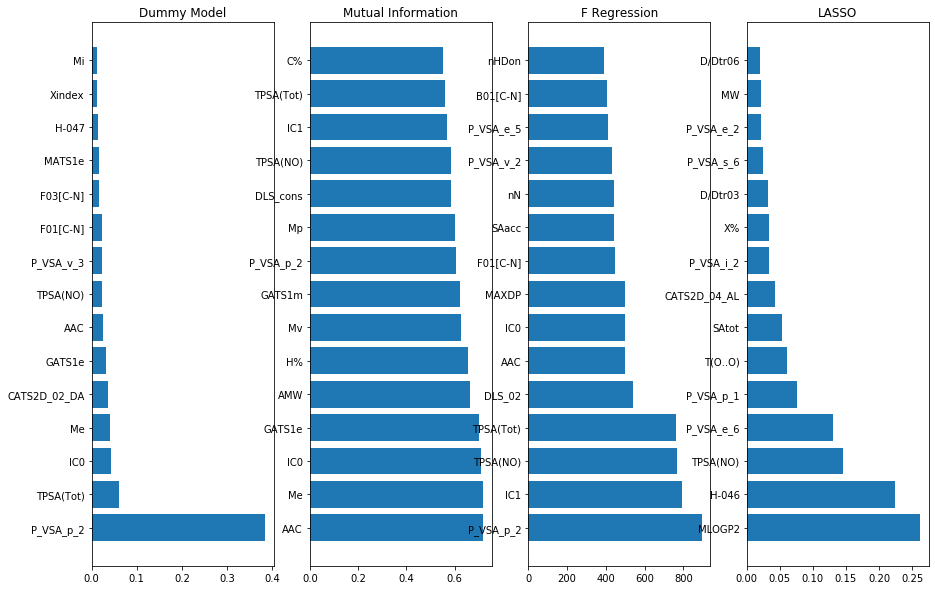

In [9]:
fig, imp_plot = plt.subplots(nrows=1, ncols=4, figsize=(15, 10))
imp_plot[0].barh(importances.nlargest(15).index.values, importances.nlargest(15))
imp_plot[0].set_title('Dummy Model')
imp_plot[1].barh(scores_mutual.nlargest(15).index.values, scores_mutual.nlargest(15))
imp_plot[1].set_title('Mutual Information')
imp_plot[2].barh(scores_f.nlargest(15).index.values, scores_f.nlargest(15))
imp_plot[2].set_title('F Regression')
imp_plot[3].barh(importances_lasso.nlargest(15).index.values, importances_lasso.nlargest(15))
imp_plot[3].set_title('LASSO')
plt.show()

## GradientBoosting
### Model-chosen features

In [10]:
gbr_param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [2, 4, 6],
    'min_samples_leaf': [3, 5, 9, 17],
    'learning_rate': [0.1, 0.05, 0.02],
    'max_features': [1.0, 0.3, 0.1],
    'loss': ['ls', 'lad', 'huber']
} #hyperparameters for each gbr grid search

In [11]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]


best_hp = grid_search_return_hp_dict(GradientBoostingRegressor(),
                                     X_train, y_train, gbr_param_grid)

gbr_model = GradientBoostingRegressor(**best_hp)
gbr_model.fit(X_train, y_train)

exp_vs_calc_gbr_model = produce_exp_vs_pred_df('top_15_features_model', gbr_model,
                                         "GradBoost, model-chosen features")

GradientBoostingRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.02, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.1, 'min_samples_leaf': 9, 'n_estimators': 2000}


TypeError: eval() arg 1 must be a string, bytes or code object

### F-regression features

In [15]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]

best_hp = grid_search_return_hp_dict(GradientBoostingRegressor(),
                                     X_train, y_train, gbr_param_grid)

gbr_freg = GradientBoostingRegressor(**best_hp)
gbr_freg.fit(X_train, y_train)

exp_vs_calc_gbr_freg = produce_exp_vs_pred_df('top_15_features_kbest', gbr_freg,
                                                    "GradBoost, f_reg features")

GradientBoostingRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 500}
Training Score:	 0.9574679680268028
Testing Score:	 0.8412910777099232
GradientBoostingRegressor run at: 2020-01-15 17:51:29.027315 . Saving to models/DRAGON_noVPAS/GradientBoostingRegressor_kbest_15_01_2020_17_51_29.joblib


### Mutual info features

In [16]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]


best_hp = grid_search_return_hp_dict(GradientBoostingRegressor(),
                                     X_train, y_train, gbr_param_grid)

gbr_mu = GradientBoostingRegressor(**best_hp)
gbr_mu.fit(X_train, y_train)

exp_vs_calc_gbr_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', gbr_mu,
                                            "GradBoost, Mutual Info")

GradientBoostingRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.02, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 5, 'n_estimators': 500}
Training Score:	 0.9256115162647272
Testing Score:	 0.8206605480078193
GradientBoostingRegressor run at: 2020-01-15 18:46:57.816832 . Saving to models/DRAGON_noVPAS/GradientBoostingRegressor_mutual_info_15_01_2020_18_46_57.joblib


### LASSO features

In [17]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]

best_hp = grid_search_return_hp_dict(GradientBoostingRegressor(), 
                                     X_train, y_train, gbr_param_grid)

gbr_lasso = GradientBoostingRegressor(**best_hp)
gbr_lasso.fit(X_train, y_train)
exp_vs_calc_gbr_lasso = produce_exp_vs_pred_df('top_15_features_lasso', gbr_lasso,
                                               "LASSO-features, GBR model")

GradientBoostingRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 2, 'max_features': 0.3, 'min_samples_leaf': 5, 'n_estimators': 500}
Training Score:	 0.9206767370690273
Testing Score:	 0.8058515449204732
GradientBoostingRegressor run at: 2020-01-15 19:36:14.967111 . Saving to models/DRAGON_noVPAS/GradientBoostingRegressor_lasso_15_01_2020_19_36_14.joblib


## Decision Tree
### Model-Chosen Features

In [18]:
dtr_param_grid = {
    'criterion': ['mse', 'friedman_mse', 'mae'], #function measuring quality of a split
    'max_depth': [5, 10, 20] , # max depth of tree
    'max_features': [5, 10, 15], # N features to be considered when looking for split
    'max_leaf_nodes': [None, 10, 15, 20, 30], #grows tree with N nodes in best-first fashion
    'min_impurity_decrease': [0.0, 0.1],
    'min_samples_leaf': [1, 2, 3], 
    'min_samples_split': [1.0, 2, 3],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.5] , 
    'splitter': ['best', 'random']
} #hyperparameters for dtr gridsearch

In [19]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]

best_hp = grid_search_return_hp_dict(DecisionTreeRegressor(), X_train, y_train, dtr_param_grid)

dtr_model = DecisionTreeRegressor(**best_hp)

dtr_model.fit(X_train, y_train)

exp_vs_calc_dtr_model = produce_exp_vs_pred_df('top_15_features_model', dtr_model,
                                         "Decision Tree, model-chosen features")

DecisionTreeRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
Training Score:	 0.9053795652033311
Testing Score:	 0.7857779153274613
DecisionTreeRegressor run at: 2020-01-15 19:39:43.684966 . Saving to models/DRAGON_noVPAS/DecisionTreeRegressor_model_15_01_2020_19_39_43.joblib


### F-regression features

In [20]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]


best_hp = grid_search_return_hp_dict(DecisionTreeRegressor(), X_train, y_train, dtr_param_grid)

dtr_freg = DecisionTreeRegressor(**best_hp)

dtr_freg.fit(X_train, y_train)

exp_vs_calc_dtr_freg = produce_exp_vs_pred_df('top_15_features_kbest', dtr_freg,
                                         "Decision Tree, freg features")

DecisionTreeRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'mae', 'max_depth': 10, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
Training Score:	 0.8696568488716836
Testing Score:	 0.7599643264268399
DecisionTreeRegressor run at: 2020-01-15 19:42:27.001093 . Saving to models/DRAGON_noVPAS/DecisionTreeRegressor_kbest_15_01_2020_19_42_27.joblib


### Mutual info features

In [21]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]

best_hp = grid_search_return_hp_dict(DecisionTreeRegressor(), X_train, y_train, dtr_param_grid)

dtr_mu = DecisionTreeRegressor(**best_hp)

dtr_mu.fit(X_train, y_train)

exp_vs_calc_dtr_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', dtr_mu,
                                         "Decision Tree, mutual info features")

DecisionTreeRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'friedman_mse', 'max_depth': 20, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
Training Score:	 0.9125384855550006
Testing Score:	 0.7840257299969178
DecisionTreeRegressor run at: 2020-01-15 19:45:28.732619 . Saving to models/DRAGON_noVPAS/DecisionTreeRegressor_mutual_info_15_01_2020_19_45_28.joblib


### LASSO features

In [22]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]

best_hp = grid_search_return_hp_dict(DecisionTreeRegressor(), X_train, y_train, dtr_param_grid)

dtr_lasso = DecisionTreeRegressor(**best_hp)

dtr_lasso.fit(X_train, y_train)

exp_vs_calc_dtr_lasso = produce_exp_vs_pred_df('top_15_features_lasso', dtr_lasso,
                                         "Decision Tree, lasso features")

DecisionTreeRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'mae', 'max_depth': 5, 'max_features': 10, 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
Training Score:	 0.7863811653972945
Testing Score:	 0.7378477846276876
DecisionTreeRegressor run at: 2020-01-15 19:48:27.790152 . Saving to models/DRAGON_noVPAS/DecisionTreeRegressor_lasso_15_01_2020_19_48_27.joblib


## AdaBoost Regressor
### Model Chosen Features

In [23]:
base_models = [ExtraTreesRegressor(n_estimators= 5,
                                   criterion= 'mse',
                                   max_features = 'log2'),
               RandomForestRegressor(n_estimators= 5,
                                     criterion= 'mse',
                                     max_features = 'sqrt',
                                     min_samples_split = 3),
              GradientBoostingRegressor(),
              DecisionTreeRegressor(),
              Lars(),
              ElasticNet()]

ada_param_grid = {
    'base_estimator' : base_models, 
    'learning_rate' : [0.3, 0.5, 0.8, 1], 
    'loss' : ['linear', 'square', 'exponential'], 
    'n_estimators' : [50, 100]
} #hyperparameters for adaboost gridsearch

In [24]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]

best_hp = grid_search_return_hp_dict(AdaBoostRegressor(), X_train, y_train, ada_param_grid)

ada_model = AdaBoostRegressor(**best_hp)

ada_model.fit(X_train, y_train)

exp_vs_calc_ada_model = produce_exp_vs_pred_df('top_15_features_model', ada_model,
                                               "AdaBoost, model features")

AdaBoostRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'base_estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False), 'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 50}
Training Score:	 0.9778736844712537
Testing Score:	 0.8540271109970984
AdaBoostRegressor run at: 2020-01-15 19:54:11.581919 . Saving to models/DRAGON_noVPAS/AdaBoostRegressor_model_15_01_2020_19_54_11.joblib


### F-regression features

In [25]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]

best_hp = grid_search_return_hp_dict(AdaBoostRegressor(), X_train, y_train, ada_param_grid)

ada_freg = AdaBoostRegressor(**best_hp)

ada_freg.fit(X_train, y_train)

exp_vs_calc_ada_freg = produce_exp_vs_pred_df('top_15_features_kbest', ada_freg,
                                               "AdaBoost, freg features")

AdaBoostRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False), 'learning_rate': 0.3, 'loss': 'exponential', 'n_estimators': 100}
Training Score:	 0.9892471124149445
Testing Score:	 0.8391827605040496
AdaBoostRegressor run at: 2020-01-15 20:00:07.366401 . Saving to models/DRAGON_noVPAS/AdaBoostRegressor_kbest_15_01_2020_20_00_07.joblib


### Mutual info features

In [26]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]

best_hp = grid_search_return_hp_dict(AdaBoostRegressor(), X_train, y_train, ada_param_grid)

ada_mu = AdaBoostRegressor(**best_hp)

ada_mu.fit(X_train, y_train)

exp_vs_calc_ada_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', ada_mu,
                                               "AdaBoost, mutual info features")

AdaBoostRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False), 'learning_rate': 0.3, 'loss': 'square', 'n_estimators': 50}
Training Score:	 0.9878520045373704
Testing Score:	 0.8166801492398043
AdaBoostRegressor run at: 2020-01-15 20:05:44.234592 . Saving to models/DRAGON_noVPAS/AdaBoostRegressor_mutual_info_15_01_2020_20_05_44.joblib


### LASSO features

In [27]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]

best_hp = grid_search_return_hp_dict(AdaBoostRegressor(), X_train, y_train, ada_param_grid)

ada_lasso = AdaBoostRegressor(**best_hp)

ada_lasso.fit(X_train, y_train)

exp_vs_calc_ada_lasso = produce_exp_vs_pred_df('top_15_features_lasso', ada_lasso,
                                               "AdaBoost, model features")

AdaBoostRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'base_estimator': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), 'learning_rate': 0.3, 'loss': 'square', 'n_estimators': 50}
Training Score:	 0.9421185489847377
Testing Score:	 0.8019236029905988
AdaBoostRegressor run at: 2020-01-15 20:11:12.356527 . Saving to models/DRAGON_noVPAS/AdaBoostRegressor_lasso_15_01_2020_20_11_12.joblib


## LASSO
### Model Chosen Features

In [28]:
lasso_param_grid = {
    'alpha':[0.2, 0.4, 0.6, 0.8],
    'max_iter':[1000, 5000, 10000, 50000],
    'selection':['cyclic', 'random']
}

In [29]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]
best_hp = grid_search_return_hp_dict(Lasso(), X_train, y_train, lasso_param_grid)
lasso_model = Lasso(**best_hp)
lasso_model.fit(X_train, y_train)

exp_vs_calc_lasso_model = produce_exp_vs_pred_df('top_15_features_model', lasso_model,
                                                 "LASSO, model features")

Lasso grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.2, 'max_iter': 1000, 'selection': 'cyclic'}
Training Score:	 0.7441838585069578
Testing Score:	 0.7598767635190887
Lasso run at: 2020-01-15 20:12:08.207769 . Saving to models/DRAGON_noVPAS/Lasso_model_15_01_2020_20_12_08.joblib


### F-regression features

In [30]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]
best_hp = grid_search_return_hp_dict(Lasso(), X_train, y_train, lasso_param_grid)
lasso_freg = Lasso(**best_hp)
lasso_freg.fit(X_train, y_train)

exp_vs_calc_lasso_freg = produce_exp_vs_pred_df('top_15_features_kbest', lasso_freg,
                                                 "LASSO, f-reg features")

Lasso grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.2, 'max_iter': 5000, 'selection': 'cyclic'}
Training Score:	 0.7036103777444165
Testing Score:	 0.7396619289263748
Lasso run at: 2020-01-15 20:12:38.502589 . Saving to models/DRAGON_noVPAS/Lasso_kbest_15_01_2020_20_12_38.joblib


### Mutual info features

In [31]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]
best_hp = grid_search_return_hp_dict(Lasso(), X_train, y_train, lasso_param_grid)
lasso_mu = Lasso(**best_hp)
lasso_mu.fit(X_train, y_train)

exp_vs_calc_lasso_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', lasso_mu,
                                                 "LASSO, mutual info features")

Lasso grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.2, 'max_iter': 1000, 'selection': 'cyclic'}
Training Score:	 0.6656586017960877
Testing Score:	 0.646561704209611
Lasso run at: 2020-01-15 20:13:07.353812 . Saving to models/DRAGON_noVPAS/Lasso_mutual_info_15_01_2020_20_13_07.joblib


### LASSO Features

In [32]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]
best_hp = grid_search_return_hp_dict(Lasso(), X_train, y_train, lasso_param_grid)
lasso_lasso = Lasso(**best_hp)
lasso_lasso.fit(X_train, y_train)

exp_vs_calc_lasso_lasso = produce_exp_vs_pred_df('top_15_features_lasso', lasso_lasso,
                                                 "LASSO, lasso features")

Lasso grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453.08570153526125, tolerance: 3.913076085273699
  positive)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 272.4959422045358, tolerance: 3.913076085273699
  positive)


{'alpha': 0.2, 'max_iter': 1000, 'selection': 'random'}
Training Score:	 0.7450139271594947
Testing Score:	 0.7548338170443302
Lasso run at: 2020-01-15 20:13:36.495831 . Saving to models/DRAGON_noVPAS/Lasso_lasso_15_01_2020_20_13_36.joblib


## Random Forest Regressor
### Model Chosen Features

In [33]:
random_forest_param_grid = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600]
}

In [34]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]
best_hp = grid_search_return_hp_dict(RandomForestRegressor(),
                                     X_train, y_train, random_forest_param_grid)
random_forest_model = RandomForestRegressor(**best_hp)
random_forest_model.fit(X_train, y_train)
exp_vs_calc_random_forest_model = produce_exp_vs_pred_df('top_15_features_model', random_forest_model,
                                                         "RandomForest, model features")

RandomForestRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
Training Score:	 0.9521365989206246
Testing Score:	 0.8540268712146579
RandomForestRegressor run at: 2020-01-15 21:50:17.703348 . Saving to models/DRAGON_noVPAS/RandomForestRegressor_model_15_01_2020_21_50_17.joblib


### F-regression features

In [35]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]
best_hp = grid_search_return_hp_dict(RandomForestRegressor(),
                                     X_train, y_train, random_forest_param_grid)
random_forest_freg = RandomForestRegressor(**best_hp)
random_forest_freg.fit(X_train, y_train)
exp_vs_calc_random_forest_freg = produce_exp_vs_pred_df('top_15_features_kbest', random_forest_freg,
                                                         "RandomForest, freg features")

RandomForestRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training Score:	 0.9528705346526167
Testing Score:	 0.8354465218254647
RandomForestRegressor run at: 2020-01-15 23:13:07.577803 . Saving to models/DRAGON_noVPAS/RandomForestRegressor_kbest_15_01_2020_23_13_07.joblib


### Mutual info features

In [36]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]
best_hp = grid_search_return_hp_dict(RandomForestRegressor(),
                                     X_train, y_train, random_forest_param_grid)
random_forest_mu = RandomForestRegressor(**best_hp)
random_forest_mu.fit(X_train, y_train)
exp_vs_calc_random_forest_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', random_forest_mu,
                                                         "RandomForest, mutual info features")

RandomForestRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training Score:	 0.9537518294456389
Testing Score:	 0.8141513176073477
RandomForestRegressor run at: 2020-01-16 00:58:16.627752 . Saving to models/DRAGON_noVPAS/RandomForestRegressor_mutual_info_16_01_2020_00_58_16.joblib


### LASSO features

In [37]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]
best_hp = grid_search_return_hp_dict(RandomForestRegressor(),
                                     X_train, y_train, random_forest_param_grid)
random_forest_lasso = RandomForestRegressor(**best_hp)
random_forest_lasso.fit(X_train, y_train)
exp_vs_calc_random_forest_lasso = produce_exp_vs_pred_df('top_15_features_lasso', random_forest_lasso,
                                                         "RandomForest, lasso features")

RandomForestRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Training Score:	 0.9718260365749242
Testing Score:	 0.7939657754112939
RandomForestRegressor run at: 2020-01-16 02:33:30.439412 . Saving to models/DRAGON_noVPAS/RandomForestRegressor_lasso_16_01_2020_02_33_30.joblib


## LARS - Least angle regression
### Model chosen features

In [38]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]

lars_model = Lars(fit_intercept=False, n_nonzero_coefs=np.inf)
lars_model.fit(X_train, y_train)
exp_vs_calc_lars_model = produce_exp_vs_pred_df('top_15_features_model', lars_model, "LARS model features")

Training Score:	 -9.109331628078547
Testing Score:	 -7.0899453132646135
Lars run at: 2020-01-16 02:33:56.400233 . Saving to models/DRAGON_noVPAS/Lars_model_16_01_2020_02_33_56.joblib


### F-regression features

In [39]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]

lars_freg = Lars(fit_intercept=False, n_nonzero_coefs=np.inf)
lars_freg.fit(X_train, y_train)
exp_vs_calc_lars_freg = produce_exp_vs_pred_df('top_15_features_kbest', lars_freg, "LARS freg features")

Training Score:	 0.3956501412957313
Testing Score:	 0.4859132800622039
Lars run at: 2020-01-16 02:34:22.398950 . Saving to models/DRAGON_noVPAS/Lars_kbest_16_01_2020_02_34_22.joblib


### Mutual info features

In [40]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]

lars_mu = Lars(fit_intercept=False, n_nonzero_coefs=np.inf)
lars_mu.fit(X_train, y_train)
exp_vs_calc_lars_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', lars_mu, "LARS mutual info features")

Training Score:	 0.6534734310573487
Testing Score:	 0.6400998580991186
Lars run at: 2020-01-16 02:34:48.668210 . Saving to models/DRAGON_noVPAS/Lars_mutual_info_16_01_2020_02_34_48.joblib


### LASSO features

In [41]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]

lars_lasso = Lars(fit_intercept=False, n_nonzero_coefs=np.inf)
lars_lasso.fit(X_train, y_train)
exp_vs_calc_lars_lasso = produce_exp_vs_pred_df('top_15_features_lasso', lars_lasso, "LARS lasso features")

Training Score:	 -164.91252493582599
Testing Score:	 -128.61572100983005
Lars run at: 2020-01-16 02:35:15.085718 . Saving to models/DRAGON_noVPAS/Lars_lasso_16_01_2020_02_35_15.joblib


## Elastic Net (linear regression l1 l2 norm regularization)
### Model chosen features

In [42]:
net_param_grid = {
    'alpha':[0.1, 0.3, 0.5, 0.8, 1.0],
    'l1_ratio':[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    'fit_intercept':[True, False],
    'max_iter': [1000, 3000, 5000],
    'tol':[0.0001, 0.001, 0.01],
    'selection':['cyclic', 'random']
}

In [43]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]
best_hp = grid_search_return_hp_dict(ElasticNet(), X_train, y_train, net_param_grid)

net_model = ElasticNet(**best_hp)
net_model.fit(X_train, y_train)
exp_vs_calc_net_model = produce_exp_vs_pred_df('top_15_features_model', net_model, "ElasticNet model features")

ElasticNet grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.1, 'fit_intercept': False, 'l1_ratio': 1.0, 'max_iter': 1000, 'selection': 'random', 'tol': 0.01}
Training Score:	 0.7611712877312111
Testing Score:	 0.7729770951356996
ElasticNet run at: 2020-01-16 02:36:32.147755 . Saving to models/DRAGON_noVPAS/ElasticNet_model_16_01_2020_02_36_32.joblib


### F regression features

In [44]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]
best_hp = grid_search_return_hp_dict(ElasticNet(), X_train, y_train, net_param_grid)

net_freg = ElasticNet(**best_hp)
net_freg.fit(X_train, y_train)
exp_vs_calc_net_freg = produce_exp_vs_pred_df('top_15_features_kbest', net_freg, "ElasticNet freg features")

ElasticNet grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5788.800639592796, tolerance: 391.3076085273699
  positive)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5788.719783481479, tolerance: 391.3076085273699
  positive)


{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.0, 'max_iter': 3000, 'selection': 'random', 'tol': 0.01}
Training Score:	 0.725098841696405
Testing Score:	 0.7623808925271665
ElasticNet run at: 2020-01-16 02:37:37.098112 . Saving to models/DRAGON_noVPAS/ElasticNet_kbest_16_01_2020_02_37_37.joblib


### Mutual info features

In [45]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]
best_hp = grid_search_return_hp_dict(ElasticNet(), X_train, y_train, net_param_grid)

net_mu = ElasticNet(**best_hp)
net_mu.fit(X_train, y_train)
exp_vs_calc_net_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', net_mu, "ElasticNet mutual info features")

ElasticNet grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6498.948922877734, tolerance: 3.913076085273699
  positive)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6498.948922877593, tolerance: 3.913076085273699
  positive)


{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.0, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}
Training Score:	 0.6805537707602638
Testing Score:	 0.6556378294323033
ElasticNet run at: 2020-01-16 02:38:23.705957 . Saving to models/DRAGON_noVPAS/ElasticNet_mutual_info_16_01_2020_02_38_23.joblib


### LASSO features

In [46]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]
best_hp = grid_search_return_hp_dict(ElasticNet(), X_train, y_train, net_param_grid)

net_lasso = ElasticNet(**best_hp)
net_lasso.fit(X_train, y_train)
exp_vs_calc_net_lasso = produce_exp_vs_pred_df('top_15_features_lasso', net_lasso, "ElasticNet lasso features")

ElasticNet grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.19492254268516, tolerance: 3.913076085273699
  positive)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 236.51879671780534, tolerance: 3.913076085273699
  positive)


{'alpha': 0.3, 'fit_intercept': True, 'l1_ratio': 1.0, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}
Training Score:	 0.7439120527288794
Testing Score:	 0.7533360156021052
ElasticNet run at: 2020-01-16 02:39:21.375397 . Saving to models/DRAGON_noVPAS/ElasticNet_lasso_16_01_2020_02_39_21.joblib


# Scores and visualisation

In [47]:
exp_vs_calc_df_list = []
model_list = []
for var in dir():
    if isinstance(eval(var), pd.core.frame.DataFrame):
        if var[0:3] == 'exp':
            exp_vs_calc_df_list.append(var)
            model_list.append(var[12:])
exp_vs_calc_model_dict = dict(zip(model_list, exp_vs_calc_df_list))

In [54]:
joblib.dump(train_scores, "train_scores.joblib")
joblib.dump(test_scores, "test_scores.joblib")

['test_scores.joblib']

In [48]:
display("Training Scores", train_scores, "Testing Scores", test_scores)
mpld3.enable_notebook() #must enable
@widgets.interact()

def show_pred_vs_actual(Model = model_list):
    pred_df = eval(exp_vs_calc_model_dict[Model])
    model = eval(Model)
    prediction_plot_scores(model, pred_df)

'Training Scores'

{'GradBoost, model-chosen features': 0.931188898638534,
 'GradBoost, f_reg features': 0.9574679680268028,
 'GradBoost, Mutual Info': 0.9256115162647272,
 'LASSO-features, GBR model': 0.9206767370690273,
 'Decision Tree, model-chosen features': 0.9053795652033311,
 'Decision Tree, freg features': 0.8696568488716836,
 'Decision Tree, mutual info features': 0.9125384855550006,
 'Decision Tree, lasso features': 0.7863811653972945,
 'AdaBoost, model features': 0.9421185489847377,
 'AdaBoost, freg features': 0.9892471124149445,
 'AdaBoost, mutual info features': 0.9878520045373704,
 'LASSO, model features': 0.7441838585069578,
 'LASSO, f-reg features': 0.7036103777444165,
 'LASSO, mutual info features': 0.6656586017960877,
 'LASSO, lasso features': 0.7450139271594947,
 'RandomForest, model features': 0.9521365989206246,
 'RandomForest, freg features': 0.9528705346526167,
 'RandomForest, mutual info features': 0.9537518294456389,
 'RandomForest, lasso features': 0.9718260365749242,
 'LARS mod

'Testing Scores'

{'GradBoost, model-chosen features': 0.8653019343397369,
 'GradBoost, f_reg features': 0.8412910777099232,
 'GradBoost, Mutual Info': 0.8206605480078193,
 'LASSO-features, GBR model': 0.8058515449204732,
 'Decision Tree, model-chosen features': 0.7857779153274613,
 'Decision Tree, freg features': 0.7599643264268399,
 'Decision Tree, mutual info features': 0.7840257299969178,
 'Decision Tree, lasso features': 0.7378477846276876,
 'AdaBoost, model features': 0.8019236029905988,
 'AdaBoost, freg features': 0.8391827605040496,
 'AdaBoost, mutual info features': 0.8166801492398043,
 'LASSO, model features': 0.7598767635190887,
 'LASSO, f-reg features': 0.7396619289263748,
 'LASSO, mutual info features': 0.646561704209611,
 'LASSO, lasso features': 0.7548338170443302,
 'RandomForest, model features': 0.8540268712146579,
 'RandomForest, freg features': 0.8354465218254647,
 'RandomForest, mutual info features': 0.8141513176073477,
 'RandomForest, lasso features': 0.7939657754112939,
 'LARS mod

interactive(children=(Dropdown(description='Model', options=('ada_freg', 'ada_lasso', 'ada_model', 'ada_mu', '…